<a href="https://colab.research.google.com/github/sonovman/DL_Term_PJT/blob/main/Tutorial_1_CIFAR10_Softmax_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 라이브러리 로드

필요한 라이브러리를 로드해줍니다.

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

#keras 새 버전 추가
from keras import utils as np_utils
import tensorflow as tf 

import os
import numpy as np
import matplotlib.pyplot as plt

## 2. 데이터셋 로드

우리는 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 데이터를 사용할 예정입니다. 

아래와 같이 CIFAR-10 데이터를 다운받아 로드해줍니다.

training 데이터셋인 (x_train, y_train)과 test 데이터 셋인 x_test, y_test가 로드되었습니다.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 8s 0us/step


### 2.1 CIFAR-10 데이터셋 알아보기

먼저, 로드된 데이터 셋을 살펴보겠습니다. 



In [ ]:
print(x_train.shape[0], 'train samples')
print(y_train.shape[0], 'train labels')
print(x_test.shape[0], 'test samples')
print(y_test.shape[0], 'test labels')

50000 train samples
50000 train labels
10000 test samples
10000 test labels


0번째 트레이닝 데이터와 레이블은 어떻게 생겼을까요?

In [ ]:
print('0번째 이미지 데이터:', x_train[0].shape)
print('0번째 데이터 레이블:', y_train[0].shape)


0번째 이미지 데이터: (32, 32, 3)
0번째 데이터 레이블: (1,)


보시는 바와 같이, 0번째 이미지 데이터는 32 by 32 픽셀이며, 

각각의 픽셀은 RGB 3개의 채널로 이루어져있습니다. 그에 해당하는 레이블은 1차원 데이터입니다.

이번에는 이미지를 그려보겠습니다.

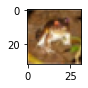

label:  [6]


In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(x_train[0].astype('uint8'))
plt.show()

print('label: ', y_train[0])

개구리 이미지였습니다. 그렇다면 레이블인 6은 무엇을 의미할까요?

사실 CIFAR-10 데이터 셋에는 10가지 클래스의 이미지들이 담겨있습니다. 

클래스들은 순서대로 다음과 같습니다.

```python
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
```

0번 인덱스 이미지는 6번 클래스, 즉 개구리라는 뜻이었습니다.  

이번에는 각 클래스당 5개정도 씩 이미지를 그려보겠습니다.

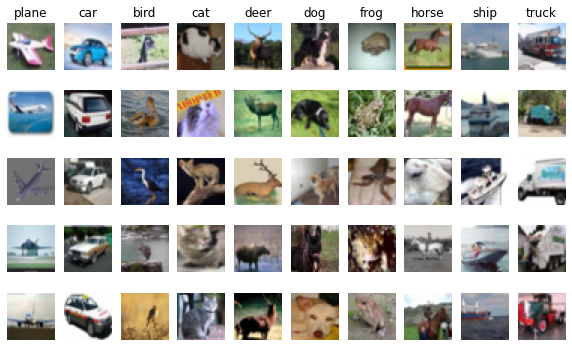

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(10,6))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

위와 같은 데이터가 트레이닝 셋에 5만개, 테스트 셋에만개가 주어져있는 CIFAR-10 데이터 였습니다.

### 2.2 클래스 이진화

y_train[0] 은 6이었지만, 머신러닝 모델이 0에서 9까지 이르는 이산적 값을 직접 예측하게 하는 것은 성능이 떨어집니다. 

그러한 방법 대신 10개의 클래스마다 0과 1 사이의 값을 가지게하는 이진 벡터 방식을 더 자주 사용합니다. 

예를 들어 y_train[0]은 6이므로

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0] 과 같은 이진 코드로 나타냅니다. 

Keras에서는 이를 자동화해주는 API를 제공합니다.

In [ ]:
# Convert class vectors to binary class matrices.
print('y_train shape (이진화 전)', y_train.shape)
print('y_train[0]:', y_train[0])

#y_train = keras.utils.to_categorical(y_train, num_classes) keras 구 버전
#y_test = keras.utils.to_categorical(y_test, num_classes) keras 구 버전
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

print('y_train shape (이진화 후)', y_train.shape)
print('y_train[0]:', y_train[0])

y_train shape (이진화 전) (50000, 1)
y_train[0]: [6]
y_train shape (이진화 후) (50000, 10)
y_train[0]: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 3. 모델 생성

이제 본격적으로 모델을 생성해보고, CIFAR-10 데이터 셋에 대해 훈련시켜보겠습니다. 

In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(100, input_shape=(32*32*3,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

## 4. 모델 학습

이제 모델을 학습시켜보겠습니다.

In [ ]:
opt = tf.keras.optimizers.Adam()

# 모델 생성
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('Not using data augmentation.')
model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test),
          shuffle=True)

Not using data augmentation.
Epoch 1/10
1563/1563 [==============================] - 9s 4ms/step - loss: 1.9004 - accuracy: 0.3176 - val_loss: 1.8290 - val_accuracy: 0.3399
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7771 - accuracy: 0.3669 - val_loss: 1.7729 - val_accuracy: 0.3651
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7421 - accuracy: 0.3752 - val_loss: 1.7087 - val_accuracy: 0.3907
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7158 - accuracy: 0.3859 - val_loss: 1.7117 - val_accuracy: 0.3901
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6937 - accuracy: 0.3907 - val_loss: 1.7166 - val_accuracy: 0.3819
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6804 - accuracy: 0.3957 - val_loss: 1.7011 - val_accuracy: 0.3849
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6672 - accuracy: 0.3995 - val

## 5. 모델 성능 테스트

모델의 성능을 테스트해보겠습니다.

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 1s 3ms/step - loss: 1.6370 - accuracy: 0.4061
Test loss: 1.6370291709899902
Test accuracy: 0.40610000491142273


정확도가 40% 정도되는 간단한 모델을 만들어보았습니다.

## Reference

- [cs231n](http://cs231n.github.io/)
- [Keras tutorial on CIFAR-10](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)



---

---





## **[주석#1] <심화학습> Softmax**

소프트맥스 함수는 n차원의 벡터를 입력하여 n차원 벡터를 출력하는 함수로 소프트맥스 함수의 출력은 0에서 1.0사이의 실수이다. 또 입력데이터 집합에 대한 소프트맥스 함수 출력의 총합은 1이다. 출력의 총합이 1이 된다는 성질때문에 소프트맥스 함수의 출력을 '확률'로 해석할 수 있다. 

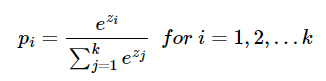

예를 들어, [5, 3, 2] 데이터 집합의 값들을 일반적으로 정규화해보았다. 정규화된 값은 데이터 집합의 합으로 각 데이터를 나눈 값이다. 정규화된 값은 [0.5, 0.3, 0.2] 이다.

In [ ]:
list = [[5, 3, 2]]
norm_list = [i / sum(j) for j in list for i in j]
print(norm_list)

[0.5, 0.3, 0.2]


반면 소프트맥스 함수로 처리하면, [0.84, 0.11, 0.04]가 되었다. 원 데이터 집합 중 제일 큰값 5 가 정규화된 값 0.5보다 더 두드러지게 커졌고, 나머지 작은값 3과 2의 값도 정규화된 값보다 훨씬 더 작아졌다.

In [ ]:
def softmax_stable(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

softmax = softmax_stable([5, 3, 2])
print(softmax)

[0.84379473 0.1141952  0.04201007]


이러한 특징들 때문에 소프트맥스 함수는 다중 클래스 분류 문제와 딥러닝 알고리즘에서 사용된다. 

세 개 이상의 선택지 중 하나를 고르는 문제를 다중 클래스 분류라고 하는데, 다중 클래스로 분류한다는 것은 여러 값을 예측하는 하나의 분류기(classifier)를 쓰는 것이 아니라 0과 1사이의 확률값을 출력하는 분류기를 여러개 만들어 사용하고 최종적으로 여러 분류기 중 확률값이 가장 큰 분류기의 클래스가 모델 전체의 예측값이 되기 때문이다. 3개 이상의 선택지 중에서 1개를 고르는 다중 클래스 분류 문제를 위한 머신러닝 알고리즘을 소프트맥스 회귀(Softmax Regression) 알고리즘이라고도 하는 이유다. 

소프트맥스 함수는 입력 데이터 집합의 원소값 들의 상대적 대소 관계를 그대로 유지하면서 입력 원소의 크기를 단조증가시켜, 0과 1사이에서 입력 데이터 집합에서 최댓값을 다른 값보다 더 증폭하는 특성을 갖는다. 

신경망을 이용한 분류에서 일반적으로 가장 큰 출력을 내는 뉴런에 해당하는 클래스만 인식하는데, 이때 가장 큰 값을 더 두드러지게 하여 신경망의 예측값을 더 확실하게 해준다.

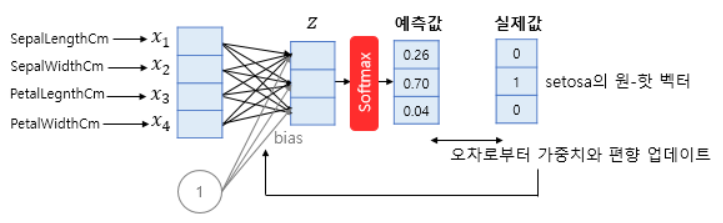

다중 클래스 분류 모델에서 소프트맥스 함수를 예측 함수로 사용하면 클래스가 원핫 인코딩된 정답값 벡터와 예측 벡터사이의 손실함수는 소프트맥스 함수와 범주형 교차 엔트로피(Categorical Cross-Entropy) 함수의 합성함수가 된다.

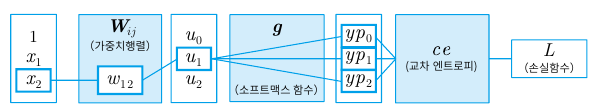

## **[주석#2] CIFAR-10 데이터 세트에 대한 보충학습**

#### **1) CIFAR-10 데이터 세트란?**

CIFAR-10 데이터 세트(Canadian Institute For Advanced Research)는 머신 러닝 및 컴퓨터 비전 알고리즘을 훈련하는 데 일반적으로 사용되는 이미지 모음이다. CIFAR-10 데이터 세트에는 10개의 다른 클래스에 60,000개의 32x32 컬러 이미지가 포함되어 있다. 10가지 클래스에는 비행기(airplane), 자동차(automobile), 새(bird), 고양이(cat), 사슴(deer), 개(dog), 개구리(frog), 말(horse), 배(ship), 트럭(truck)을 나타낸다. 각 클래스당 6000개의 이미지가 있다.

사진 속의 물체를 인식하기 위한 컴퓨터 알고리즘은 종종 예를 통해 배운다. CIFAR-10은 컴퓨터에게 사물을 인식하는 방법을 배우는 데 사용할 수 있는 이미지 모음이다. 

CIFAR-10의 이미지는 저해상도(32x32)이기 때문에, 이 데이터 세트는 연구자들이 무엇이 작동하는지 보기 위해 다른 알고리즘을 빠르게 시도할 수 있게 해준다. 다양한 종류의 경련신경망은 CIFAR-10에서 영상을 가장 잘 인식하는 경향이 있다.

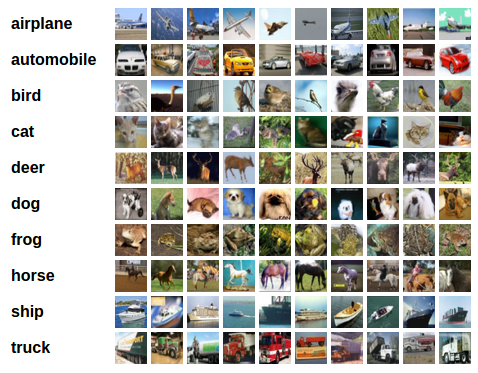

In [ ]:
# CIFAR-10 클래스
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

<참고> https://www.cs.toronto.edu/~kriz/cifar.html

#### **2) CIFAR10 데이터셋 불러오기**


Keras에서 제공하는 CIFAR-10 데이터를 불러오는 함수 cifar10.load_data()를 사용하여 데이터 세트를 불러온다.

CIFAR-10 데이터는 이미 네 부분으로 나뉘어 있는데, 첫 번째 부분을 X_train으로, 두 번째 부분을 y_train으로, 세 번째 부분을 X_test로, 마지막 부분을 y_test로 불러오라는 명령어이다. 그리고 이 값들은 모두 넘파이 라이브러리를 사용하여 만든 값이다. 

앞으로 이 값들을 사용할 때 넘파이 라이브러리의 다양한 함수, 예를 들어 데이터의 형태를 바꾸는 reshape 함수 같은 여러 함수를 사용할 수 있다.

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

training 데이터셋인 (X_train, y_train)과 test 데이터 셋인 X_test, y_test가 로드되었다.

본 보충학습에서는 Train data를 다시 Train data와 Validation data로 나누는 작업은 생략하기로 한다. Train data와 Validation data로 나누는 이유는 나중에 Overfitting 여부를 점검하기 위해서이다.

####**3) CIFAR10 데이터 세트 형태 확인**

#### **Train 데이터 세트**

In [ ]:
X_train.shape

(50000, 32, 32, 3)

첫번째 ( i = 0 ) X_train 이미지 데이터의 차원(크기)는 앞에서 보는 바와 같이 32 X 32 X 3 이다.

In [ ]:
y_train.shape

(50000, 1)

y_train 데이터는 x_train 데이터의 정답을 말한다. 정답을 표시하였다고 하여 "레이블"(label)이라고도 한다. 

레이블(y_train 데이터)는 x_train의 데이터 개수가 50,000 개이었으므로 또한 50,000개가 되어야 한다. 

y_train의 shape를 확인한 결과 데이터의 개수가 50,000개이며, 각 이미지의 셀은 1차원의 크기를 갖는 것을 알 수 있다.

레이블 데이터를 확인해 본다. 

In [ ]:
display(y_train)

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)


레이블 데이터가 레이블별로 몇개의 데이터로 구성되어 있는지 확인해본다.

In [ ]:
unique, counts = np.unique(y_train, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))

uniq_cnt_dict

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

#### **Test 데이터 세트**

검증용 test 데이터 (x_test)의 shape를 보면 총 10,000개이고, 그 크기는 taining 데이터와 마찬가지로 (32, 32, 3)임을 알 수 있습니다.

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
y_test.shape

(10000, 1)

Test 데이터 각 이미지별 레이블은 10,000개가 있다.

####**4) CIFAR10 데이터 세트 시각화**

하나의 픽셀은 각 채널 데이터마다 0~ 255 사이의 256개의 숫자로 이루어져 있다. 가장 짙은색은 0, 가장 밝은색은 255, 그 중간색은 1~254 사이의 숫자로 표현된다.

Train 데이터의 첫번째 데이터 (i = 0)를 대표적으로 확인해본다.

In [ ]:
x_train[0] ## 3채널 RGB 이미지 (R, G, B) 데이터가 32 X 32 차원으로 구성됨 

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [ ]:
print('첫 번째(i=0) 이미지 데이터:', x_train[0].shape)


첫 번째(i=0) 이미지 데이터: (32, 32, 3)


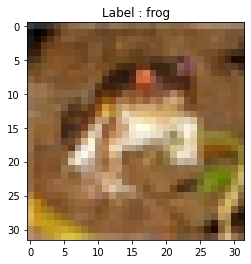

In [ ]:
plt.imshow(X_train[0], interpolation='nearest')
plt.title('Label : {}'.format(CIFAR10_CLASSES[y_train[0][0]]))
plt.show()

y_train의 첫번째(i=0)의 데이터는 오직 한 개의 데이터로 구성되어 있다. 즉 1차원 배열을 의미한다.

In [ ]:
print('0번째 데이터 레이블:', y_train[0].shape)

0번째 데이터 레이블: (1,)


요약하면, train 데이터의 첫번째(i=0) 이미지 데이터는 32 by 32 픽셀이며, 각각의 픽셀은 RGB 3개의 채널로 이루어져있다. 그에 해당하는 레이블 데이터는 1차원 데이터이다. 

조금 더 많은 CIFAR 데이터셋을 확인해본다.

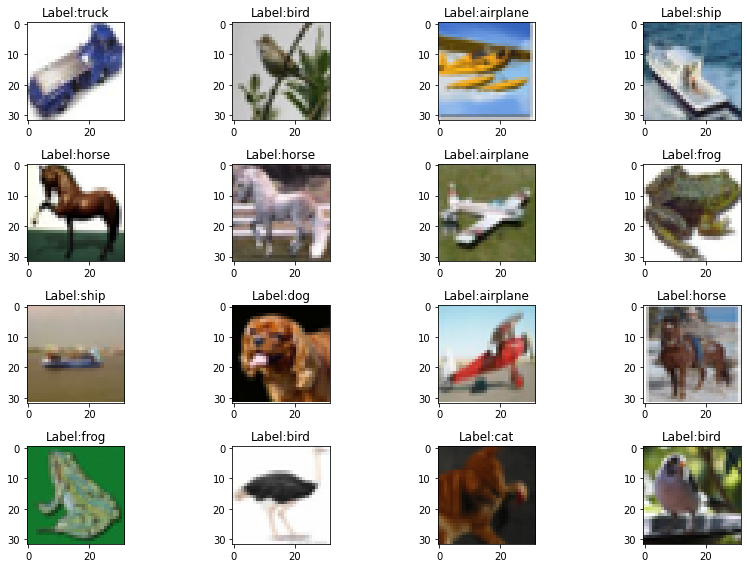

In [ ]:
# 재연성을 위하여 랜덤시드 고정
np.random.seed(1234) 

# random 함수를 통해서 임의의 16개 데이터 가져오기
samples = np.random.randint(0,len(X_train)+1,size=16)

# MNIST를 그릴 Figure 준비
plt.figure(figsize=(12,8))

# 16개의 이미지 시각화
for count, n in enumerate(samples,start=1):
    plt.subplot(4, 4, count)
    plt.imshow(X_train[n], interpolation='nearest')
    label_name = "Label:" + str(CIFAR10_CLASSES[y_train[n][0]])
    plt.title(label_name)

plt.tight_layout()
plt.show()

## **[주석#3] 데이터의 전처리 보충학습**

생성한 데이터를 인공지능 모델에 넣을 수 있도록 형태를 변환할 필요가 있는 경우에는 데이터의 형태를 변환한다. 데이터를 넣을 때 한 줄씩 넣는 것과 통째로 넣는 것에는 차이가 있다.

<참고> 
- https://thebook.io/080244/part04/unit17/06/
- https://thebook.io/080244/part04/unit16/03/

####**1) 데이터 크기 조정(Data Reshape)**

In [ ]:
# 불러온 데이터는 크기를 조정(Data Reshape)할 필요가 없으나 형식으로 코드를 남겨 둔다.
X_train = X_train.reshape(X_train.shape[0],32,32,3)
X_test = X_test.reshape(X_test.shape[0],32,32,3)

####**2) 데이터 정규화(Data Regularization)**

머신러닝에서의 핵심중 하나는 손실(loss)을 구하고 Gradient Descent와 같은 알고리즘을 사용하여 손실(Loss)를 최소화 시키는 것이다. 그렇게 하기 위해 적당한 Learning Rate값을 찾는 것이 중요하다. 

그런데, 정규화되지 않은 데이터셋은 타원모양으로 길게 늘어져 Learning Rate를 매우 작게 해야지만 학습이 될 수 있다. 만약 충분히 작지 않다면 수평으로 이동할 때와 수직으로 이동할 때 불균형이 발생하여 Gradient Descent 알고리즘을 적용하기 어려울 수 있다.

반면에 정규화된 데이터셋은 구의 모양을 띄고 있다. 때문에 Gradient Descent알고리즘을 적용하여 쉽고 빠르게 최적화 지점을 찾을 수 있다.

때문에 최적의 머신러닝을 하기 위해선 데이터에 대한 정규화작업을 거치는 것이 반드시 필요하다.

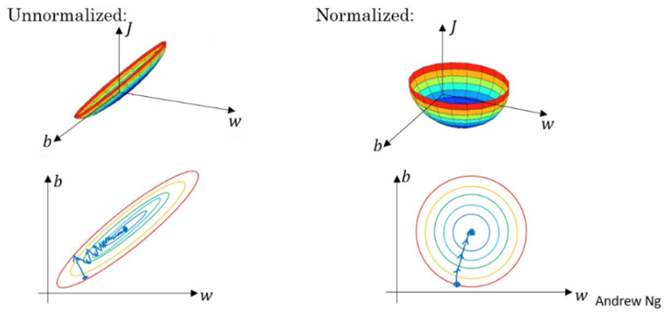

정규화하기 위해 데이터를 0~1 사이의 값으로 바꿔 주려고 한다. 이 값들은 모두 실수값이라서 정수형의 데이터를 자료형을 바꿔 주어야 한다. 이를 위해 데이터의 형태를 실수 형태로 바꾸고 그 데이터를 다시 변수에 넣는다.

In [ ]:
# 정수(int)인 데이터에서 실수(float)으로 변환
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

앞에서 데이터의 각 형태를 살펴봤듯이 각 픽셀의 데이터 값은 0~ 255 사이의 값으로 이루어져 있다. 

따라서 이를 0~1 사이의 값으로 바꾸는 방법은 바로 255로 나누는 것이다. 각 데이터를 255로 나눈 값을 다시 변수에 저장한다.

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
print("X Training matrix shape", X_train.shape)
print("X Testing matrix shape ", X_test.shape)

X Training matrix shape (50000, 32, 32, 3)
X Testing matrix shape  (10000, 32, 32, 3)


####**3) 데이터의 수치형 레이블을 범주형 데이터로 벡터화(Vectorize)**

현재 수치형 레이블인 [0,1,2,3,4,5,6,7,8,9]를 레이블 수치간에 관계가 성립된다. 예를 들어 1은 9보다 0에 더 가깝다. 3은 2보더 더 크고 1보다 더 작은 수이다. 인공지능이 범주를 분류하는 데에는 이러한 정보는 불필요하다. 

각 레이블이 독립적이어야 한다. 이때 사용하는 방법이 범주의 수만큼을 데이터로 나열한 원-핫 인코딩(one-hot incoding)이다.

예) [3] -> [0 0 0 1 0 0 0 0 0 0]

In [ ]:
# Keras의 to_categorical함수를 이용하여 모든 레이블 데이터를 벡터화(Vectorize) 한다.

num_classes = len(CIFAR10_CLASSES)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [ ]:
print("y Training matrix shape", y_train.shape)
print("y Testing matrix shape", y_test.shape)

y Training matrix shape (50000, 10)
y Testing matrix shape (10000, 10)


## **[주석#4] 학습 모델링**

####**1) 모델 구성 (설계)**

모델은 본 Tutorial에서 제공된 모델을 그대로 따르기로 한다. 

단, 원 코드 그대로 사용하면 model.summary() 명령시 build 가 되지 않은 모델이라는 에러에러 메시지가 나온다. 그때는 하라는 대로 build나 fit을 해 주거나 모델을 만들 때 input_shape 옵션을 추가한다.

In [ ]:
model2 = Sequential()
model2.add(keras.Input(shape=(32,32,3)))
model2.add(Flatten())
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dense(10))
model2.add(Activation('softmax'))

[케라스 Sequential 모델 시작하기](https://keras.io/ko/getting-started/sequential-model-guide/)

####**2) Flatten 입력층**

설계된 모델을 보면, 맨처음 Flatten 층이 나온다. Flatten 층은 Dense와 같이 분류를 위한 학습 레이어에서는 1차원 데이터로 바꾸어서 학습이 되어야 하기에 Flatten Layer가 2차원 데이터를 1차원 데이터로 바꾸는 역할을 한다.

이와 같이 학습모델의 처음에 Flatten layer를 설계할 수도 있지만 reshape 함수을 이용하여 학습모델에 입력될 데이터를 전처리하는 단계에서 변환시키기도 한다.

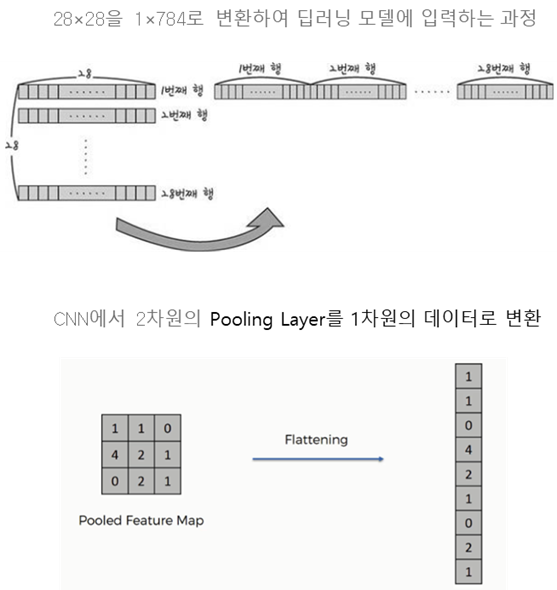

####**3) 모델 컴파일링**

In [ ]:
opt = tf.keras.optimizers.Adam()

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

####**4) 모델 확인**

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 activation_2 (Activation)   (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
Total params: 308,310
Trainable params: 308,310
Non-trainable params: 0
_________________________________________________________________


# **모델 성능 개선을 위한 시도**

**40% 수준이었던 오리지널 튜터리얼 모델 성능을 개선해보고자 1) 한번은 데이터 증강 학습을 시도해보고, 2) 다른 한번은 더 많은 레이어를 추가하고 노드를 추가하여 학습해보고, 3) 마지막으로 에포크를 50회로 늘려 학습해 보고자 한다.**

## **[1] 데이터 증강 학습**

본 실습의 학습데이터 자체가 몇천개 수준의 작은 크기가 아니라 5 만개이기에 학습하기에는 적지 않은 데이터이다. 따라서 굳이 데이터 증강이 필요한지는 의문이나, 성능의 차이와 공부를 위해 적용해본다.

사실 오리지널 튜터리얼 모델이 39% 수준이었으나 학습의 에포크가 단 10회이었던 점을 고려하면 학습 에포크만 늘려도 상당 수준으로 정답으로 수렴할 여지가 있어 보인다.

###**1) 데이터 증강(Data Augmanetation)**

딥러닝 모델에서 성능을 높이고 오버피팅을 극복할 수 있는 가장 좋은 방법은 다양한 유형의 학습 데이터의 양을 늘리는 것이다. 그러나 이미지 데이터는 학습 데이터의 양을 늘리기 쉽지 않다. 

학습할 때 학습 데이터를 늘리는 효과를 내도록 고안된 기법이 바로 Augmanetation이다. 이 기법을 사용하여 학습할 때만 원본 이미지에 다양한 변형을 가해 학습 이미지 데이터를 늘리는 효과를 내고 있다. 

**단, 오해하지 말것은 Augmanetation은 원본 학습 이미지의 개수를 늘리는 것이 아니라, 학습시마다 개별 원본 이미지를 변형해서 학습하는 것이고, 테스트 할 때는 전단이나 회전등과 같은 이미지 변화를 주어서 안된다는 것을 주의하여야 한다.**

변형은 크게 공간레벨 변형(Flip, Crop, **Affine**)이 있고, 픽셀레벨 변형(Blur, Contrast, Hue etc)이 있다. 

**[Affine Transformation]**

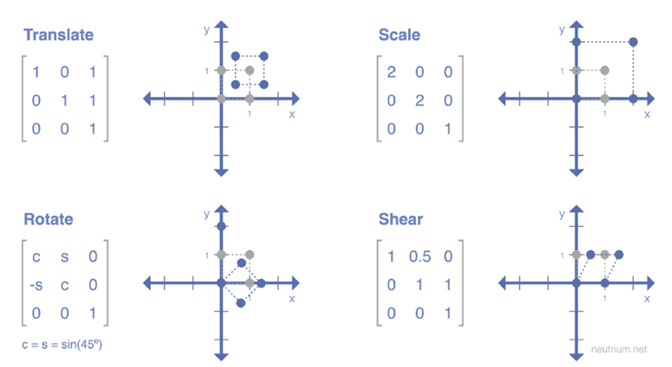

**[Keras ImageDataGenerator 이해]**
Keras에서 제공하는 ImageDataGenerator 클래스는 이미지 augmentation을 도와주는 도구로 다음과 같은 기능을 제공한다.

- 학습 도중에 이미지에 임의 변형 및 정규화 적용
- 변형된 이미지를 배치 단위로 불러올 수 있는 generator 생성.

> . generator를 생성할 때 flow(data, labels), flow_from_directory(directory) 두 가지 함수를 사용.

>. fit_generator, evaluate_generator 함수를 이용하여 generator로 이미지를 불러와서 모델을 학습 가능.

https://keras.io/ko/preprocessing/image/

**<빠른 사용법 가이드>**

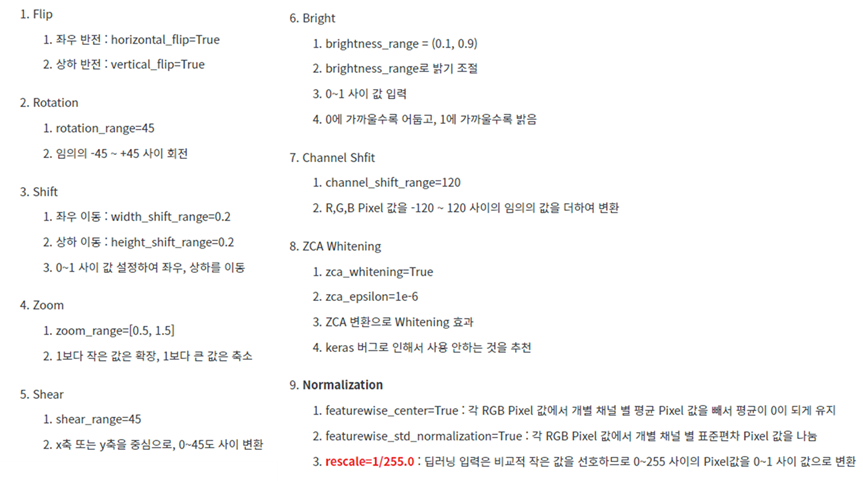


**[Train용 ImageDataGenerator 설정]**

앞에서 데이터의 정규화를 이미 진행하였으므로 정규화 설정은 하지 않기로 한다.

In [ ]:
datagen = ImageDataGenerator(
#   featurewise_center=True,
#   featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

**[Train 데이터 Augmentation 적용]**

ImageDataGenerator는 fit(), flow()를 통해서 입력된 image array(numpy)를 변환 동작한다.
- fit() : 특성별 변형에 필요한 수치를 계산(데이터 의존적인 변형에 관련된 내적 데이터 통계를 계산)
- flow() : 데이터와 라벨 배열을 받아 증강된 데이터의 배치를 생성한다. return 결과는 (x, y) 튜플을 만들어내는 Iterator 이다.

In [ ]:
# ImageDataGenerator 적용(fit)
datagen.fit(X_train)

**[Train 데이터 Augmentation 변환(학습)]**

앞에서 언급한 바와 같이 Augmanetation은 원본 학습 이미지의 개수를 늘리는 것이 아니라, 학습시마다 개별 원본 이미지를 변형해서 학습하는 것이다. 테스트 할 때는 전단이나 회전등과 같은 이미지 변화는 주지 않는다. 본 실습에서 학습데이터의 증가시 이미지 크기는 변경하지 않았으므로 test 데이터는 Augmentation을 아예 적용하지 않기로 한다.

In [ ]:
# 나중에 모델을 학습하는 단계에서 fit_generator와 디버깅 flow()를 이용하여 변환한다.
# model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),steps_per_epoch=len(x_train) / 32, epochs=epochs)

###**2) 데이터 증강 모델 학습하기**

이제 모델을 학습해본다. 이때 앞에서 잠시 미루어 두었던 데이터를 증강하면서 학습을 진행한다. 튜토리얼과 같이 에포크는 10, 배치는 32로 적용한다.



In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
train_set = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [ ]:
model2.fit(train_set,steps_per_epoch=len(X_train)//BATCH_SIZE, epochs= EPOCHS, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
1562/1562 [==============================] - 33s 21ms/step - loss: 2.0809 - accuracy: 0.2248 - val_loss: 1.9834 - val_accuracy: 0.2664
Epoch 2/10
1562/1562 [==============================] - 33s 21ms/step - loss: 1.9998 - accuracy: 0.2645 - val_loss: 1.9129 - val_accuracy: 0.2983
Epoch 3/10
1562/1562 [==============================] - 33s 21ms/step - loss: 1.9747 - accuracy: 0.2776 - val_loss: 1.9038 - val_accuracy: 0.3018
Epoch 4/10
1562/1562 [==============================] - 32s 20ms/step - loss: 1.9602 - accuracy: 0.2799 - val_loss: 1.8954 - val_accuracy: 0.3068
Epoch 5/10
1562/1562 [==============================] - 32s 21ms/step - loss: 1.9544 - accuracy: 0.2801 - val_loss: 1.8957 - val_accuracy: 0.2998
Epoch 6/10
1562/1562 [==============================] - 33s 21ms/step - loss: 1.9510 - accuracy: 0.2830 - val_loss: 1.9009 - val_accuracy: 0.2864
Epoch 7/10
1562/1562 [==============================] - 32s 21ms/step - loss: 1.9465 - accuracy: 0.2869 - val_loss: 1.8625 -

###**3) 데이터 증강 모델의 성능 평가**





데이터 증강 없이 학습한 튜토리얼 오리지널 모델에서 10회 에포크 기준, 손실(Test loss) 약 1.6, 정확도(Test accuracy) 약 39% 이었을 때, 데이터 증강 학습한 모델의 성능은,  손실(Test loss)은 약 1.8, 정확도(Test accuracy)는 약 37% 로 나왔다.

데이터 증강 학습이 성능이 더 떨어진 것을 확인할 수 있다.

In [ ]:
scores = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 1s 3ms/step - loss: 1.8864 - accuracy: 0.3046
Test loss: 1.8863919973373413
Test accuracy: 0.3046000003814697


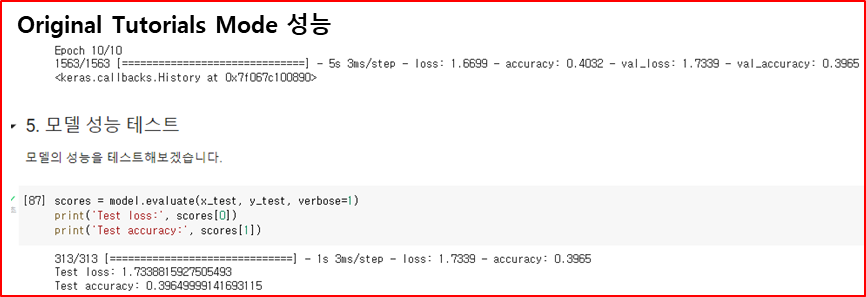

###**4) 잘못 예측한 이미지 확인**





RenNet으로 학습한 신경망이 과연 어떠한 이미지를 틀리게 예측했는지를 확인해 본다.

313/313 [==============================] - 1s 2ms/step


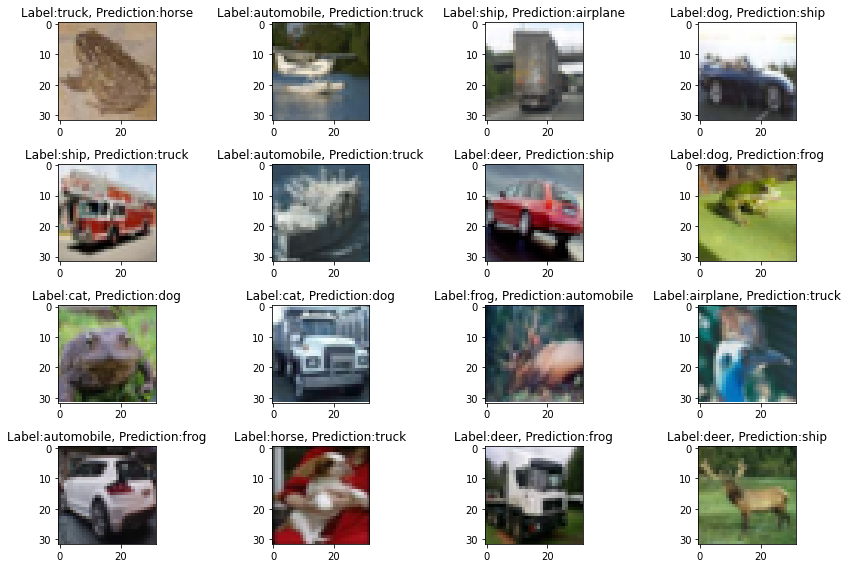

In [ ]:
import random

# 재연성을 위하여 랜덤시드 고정
random.seed('intel') 

# TEST 데이터 예측하기
predicted_result = model2.predict(X_test) 
predicted_labels = np.argmax(predicted_result, axis=1)

# TEST 데이터의 정답 가져오기
test_labels = np.argmax(y_test, axis=1)

# 잘못 예측한 데이터 찾기
wrong_result = []
for n in range(0, len(test_labels)):
    if predicted_labels[n] != test_labels[n]:
        wrong_result.append(n)

# random 함수를 통해서 임의의 16개 데이터 가져오기
samples = random.choices(population=wrong_result, k=16)

# CIFAR10를 그릴 Figure 준비
plt.figure(figsize=(12,8))

# 16개의 이미지 시각화
for count, n in enumerate(samples,start=1):
    plt.subplot(4, 4, count)
    plt.imshow(X_train[n], interpolation='nearest')
    label_name = "Label:" + str(CIFAR10_CLASSES[test_labels[n]])
    pred = "Prediction:" + str(CIFAR10_CLASSES[int(predicted_labels[n])])
    plt.title(label_name+', '+pred)

plt.tight_layout()
plt.show()

## **[2] 모델의 개선 (DENSE 층의 추가)**

In [ ]:
# CIFAR-10 클래스
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Keras에서 제공하는 CIFAR-10 데이터를 불러오는 함수 : cifar10.load_data()
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

# 데이터 크기 조정(Data Reshape)
X_train = X_train.reshape(X_train.shape[0],32,32,3)
X_test = X_test.reshape(X_test.shape[0],32,32,3)

# 데이터 포맷 바꾸기
# 정수(int)인 데이터에서 실수(float)으로 변환
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 데이터 정규화(Data Regularization)
X_train = X_train / 255
X_test = X_test / 255

# 원-핫 인코딩(One Hot Encoding)
# Keras의 to_categorical함수를 통해서 모든 Train 데이터의 레이블을 벡터화(Vectorize)
num_classes = len(CIFAR10_CLASSES)
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

####**1) 모델 구성 (설계#1)**

[케라스 Sequential 모델 시작하기](https://keras.io/ko/getting-started/sequential-model-guide/)

모델은 본 Tutorial에서 제공된 모델에 아래와 같이 Dense 층 하나를 더 추가해본다.

In [ ]:
model3 = Sequential()

모델 이름을 model3 이라 정하고, 시퀀셜(Sequential) 방식의 모델로 정의하였다. Sequential 모델은 레이어를 선형으로 연결하여 구성 방식이다. 케라스는 시퀀셜 모델을 통해 이러한 형태의 딥러닝 모델을 쉽게 개발할 수 있도록 도와준다.

In [ ]:
model3.add(keras.Input(shape=(32,32,3)))

모델에 입력층을 추가하였다. 모델에 층을 추가하는 명령어는 add 이다. 입력층의 input 함수의 인자인 input_shape은 입력하는 데이터의 형태이다. 입력되는 데이터의 형태(input_shape)는 (32, 32, 3)이다. 나중에 모델의 형태를 summary 명령어로 확인하려면 이 입력층의 정의가 꼭 필요하다.

In [ ]:
model3.add(Flatten())

다음의 첫 은닉층에 Flatten 층을 추가하였다. Flatten Layer가 1차원 데이터로 바꾸는 역할을 한다. 다음에 적층할 Dense 층과 같이 분류를 위한 학습 레이어에서는 1차원 데이터로 바꾸어 학습이 되기 때문이다. 

(32 X 32 X 3)의 3차원 배열을 1열의 배열 데이터로 변화시킨다. 따라서 Flatten 층을 통과한 데이터는 3,072 = 32 X 32 X 3 개가 된다. 3개의 R,G,B 데이터 채널로 구성된 32 X 32 픽셀 데이터가 모델 학습을 위해 이런 모습으로 바뀐다. 

이 데이터를 다음 은닉층의 노드는 1024개로 처리하는 것으로 설계 해보겠습니다.

In [ ]:
model3.add(Dense(1024))
model3.add(Activation('relu'))

두번째 은닉층의 뉴런 수는 1024 이다. 다음 은닉층으로 갈 때 활성화 함수는 렐루(ReLU) 함수를 사용하였다. ReLU 함수는 0보다 작은 값이 입력되면 0을 반환하고, 0보다 큰 값이 입력되면 그 값을 그대로 반환한다.

In [ ]:
model3.add(Dense(512))
model3.add(Activation('relu'))

세번째 은닉층의 뉴런 수는 512 로 정하였다. 다음 은닉층으로 가는 활성화 함수는 역시 렐루(ReLU) 함수를 사용하였다.

In [ ]:
model3.add(Dense(256))
model3.add(Activation('relu'))

네번째 은닉층의 뉴런 수는 256 으로 정하였다. 다음 은닉층으로 가는 활성화 함수는 역시 렐루(ReLU) 함수를 사용하였다.

In [ ]:
model3.add(Dense(10))
model3.add(Activation('softmax'))

마지막 은닉층의 뉴런 수는 10 로 정하고, 활성화 함수는 소프트맥스 함수를 사용하였다. 마지막 층을 10 개의 노드로 구성한 이유는 CIFAR 데이터셋의 레이블 범주가 10 개 이기에 최종 결괏값이 0부터 9까지의 수 중 하나로 결정되어야 하기 때문입니다. 10개 노드의 소프트맥스 함수의 결과값이 0~1 사이에서 각 범주에 속할 확률값이 된다.

####**2) 모델 컴파일링**

In [ ]:
opt = tf.keras.optimizers.Adam()

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

####**3) 모델 확인**

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              3146752   
                                                                 
 activation_4 (Activation)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 activation_5 (Activation)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 activation_6 (Activation)   (None, 256)              

####**4) 모델 학습**

In [ ]:
print('Not using data augmentation.')
model3.fit(X_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(X_test, y_test),
          shuffle=True)

Not using data augmentation.
Epoch 1/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.8648 - accuracy: 0.3223 - val_loss: 1.7089 - val_accuracy: 0.3835
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6709 - accuracy: 0.3973 - val_loss: 1.6203 - val_accuracy: 0.4091
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5880 - accuracy: 0.4297 - val_loss: 1.5622 - val_accuracy: 0.4406
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5330 - accuracy: 0.4493 - val_loss: 1.5034 - val_accuracy: 0.4675
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4894 - accuracy: 0.4671 - val_loss: 1.4807 - val_accuracy: 0.4760
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4579 - accuracy: 0.4775 - val_loss: 1.5234 - val_accuracy: 0.4576
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4255 - accuracy: 0.4881 - val

####**5) 모델 성능평가**

모델에 Dense층을 추가하고 은닉층의 노드를 증가시키자 10회의 에포크만에 성능이 약 49%로 증가하였다. 오리지널 모델보다 더 빠르게 10% 증가를 보였다.

In [ ]:
scores = model3.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 1s 3ms/step - loss: 1.4262 - accuracy: 0.4969
Test loss: 1.4262429475784302
Test accuracy: 0.4968999922275543


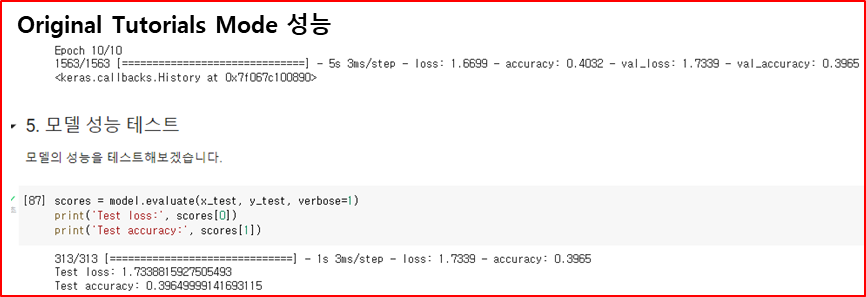

## **[3] Epoch 횟수 증가**

In [ ]:
model4 = Sequential()

model4.add(keras.Input(shape=(32,32,3)))
model4.add(Flatten())
model4.add(Dense(1024))
model4.add(Activation('relu'))
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dense(10))
model4.add(Activation('softmax'))

In [ ]:
opt = tf.keras.optimizers.Adam()
model4.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

마지막으로 앞의 모델 model3에서 **에포크만 50회로 늘려 다시 학습해본다**.

####**1) Model3 에 대한 에포크 증가 학습**

In [ ]:
EPOCHS = 50

In [ ]:
print('Not using data augmentation.')
model4.fit(X_train, y_train,
          batch_size=32,
          epochs=EPOCHS,
          validation_data=(X_test, y_test),
          shuffle=True)

Not using data augmentation.
Epoch 1/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8628 - accuracy: 0.3257 - val_loss: 1.6766 - val_accuracy: 0.3927
Epoch 2/50
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6792 - accuracy: 0.3945 - val_loss: 1.6036 - val_accuracy: 0.4246
Epoch 3/50
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5918 - accuracy: 0.4255 - val_loss: 1.5684 - val_accuracy: 0.4314
Epoch 4/50
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5353 - accuracy: 0.4468 - val_loss: 1.5153 - val_accuracy: 0.4579
Epoch 5/50
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4956 - accuracy: 0.4630 - val_loss: 1.5301 - val_accuracy: 0.4476
Epoch 6/50
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4593 - accuracy: 0.4717 - val_loss: 1.4776 - val_accuracy: 0.4763
Epoch 7/50
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4294 - accuracy: 0.4842 - val

####**2) 모델 성능평가**

모델에 Dense층을 추가하고 은닉층의 노드를 증가시킨 모델을 이용하여 에포크를 50회로 늘려보았으나 성능이 약 47% 수준에 머물렀다. 학습 히스토리를 보니 에포크 15회 정도에서 최고의 성능을 발휘하였다가 최소 소실점을 벗어난 것으로 보인다.

In [ ]:
scores = model4.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 1s 3ms/step - loss: 2.4088 - accuracy: 0.4754
Test loss: 2.408776044845581
Test accuracy: 0.47540000081062317


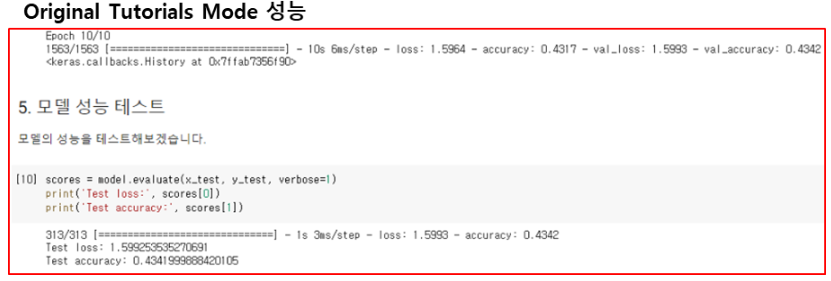

## **[4] 시사점**

충분한 데이터를 가지고 학습할 때는 데이터 변형을 이용한 증강 학습은 오히려 성능을 떨어뜨릴 수 있다는 것을 확인하였다. 

데이터 수가 충분할 때는 데이터 증강 보다는 모델의 은닉층과 노드수를 적정하게 증가시키는 것이 학습의 성능 개선에 더 도움이 된 다는 사실을 확인하였다. 

퍼셉트론 딥러닝 모델만으로는 한계가 있는 것 같다.

## Reference

- [cs231n](http://cs231n.github.io/)
- [Keras tutorial on CIFAR-10](https://github.com/valohai/keras-example/blob/master/cifar10_cnn.py)
- [Upgrade to Keras 2.3.1 and TensorFlow 2.0.0](https://github.com/valohai/keras-example/commit/3fd41c6e3b13c9d8eff8a1384a4d35036fcfb946#diff-5f0a65e4687583ca5d6c986227f1051ac67ccea277b78ae9ee4ef2d99f4c59f2) 
- [정착소/2020_01_22 CIFAR10](https://settlelib.tistory.com/5)
- [minsuk-sung/intel-image-classification](https://github.com/minsuk-sung/intel-image-classification/blob/master/Lecture04%20-%20CIFAR10.ipynb)
- [hongik_2020/material/deep_learning/data_augmentation.ipynb](https://github.com/dhrim/hongik_2020/blob/master/material/deep_learning/data_augmentation.ipynb)
- [KEKOxTutorial/ 작은 데이터셋으로 강력한 이미지 분류 모델 설계하기](https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/)
- [이미지 처리 IRIS, MNIST, CIFAR10](https://blog.naver.com/PostView.nhn?blogId=bigdata-pro&logNo=221780392503)
- [WooChan Seon/CNN-Convolutional Filter의 이해](https://woochan-autobiography.tistory.com/883)
- [WooChan Seon/CNN-Convolutional Feature Map 크기 이해](https://woochan-autobiography.tistory.com/884)
- [WooChan Seon/CIFAR10_Computer Vison/CNN](https://woochan-autobiography.tistory.com/885)
- [WooChan Seon/CNN-Data Augmentation](https://woochan-autobiography.tistory.com/890)

- [How to Develop a CNN From Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- [DL Image Classification using CNN with CIFAR-10 Dataset on Keras](https://hdevstudy.tistory.com/116)
- [딥러닝 Tensorflow-MNIST Data](https://maru-jang.tistory.com/2)
- [러닝 텐서플로 Chap04 - 합성곱 신경망 CNN](https://excelsior-cjh.tistory.com/152)
- [이미지 데이터 처리를 위한 CNN 완벽 가이드 - CIFAR-10 분류 CNN 모델 구현](https://insengnewbie.tistory.com/208)
- [호롤리한 하루, CIFAR-10 이미지 분류를 위한 CNN을 구성해보자! (Keras) Overview](https://gruuuuu.github.io/machine-learning/cifar10-cnn/)
- [TheBook by Gilbut/인공지능 모델에 넣어줄 형태로 변환하기](https://thebook.io/080244/part04/unit17/06/) 
- [TheBook by Gilbut/mnist 데이터셋에서 X의 형태 바꾸기](https://thebook.io/080244/part04/unit16/03/)
- [WikiDocs/06-09 소프트맥스 회귀(Softmax Regression)](https://wikidocs.net/35476)
- [Tutorials > PyTorch로 딥러닝하기: 분류기(CLASSIFIER) 학습하기](https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html)
- [Beeline's blog>CNN으로 CIFAR-10 데이터를 분류해보자](https://beelinekim.tistory.com/60)
- [Beeline's blog>CIFAR-10 데이터 분석하기](https://beelinekim.tistory.com/63)
- [Beeline's blog>tf.keras로 CIFAR-10 데이터 학습하기](https://beelinekim.tistory.com/66)

- [지그시 PyTorch RNN 모델 사용 예제 - CIFAR10 이미지 분류하기](https://glanceyes.tistory.com/entry/PyTorch-RNN-%EB%AA%A8%EB%8D%B8-%EC%82%AC%EC%9A%A9-%EC%98%88%EC%A0%9C-CIFAR10-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0)
- [ImageDataGenerator 사용하여 CIFAR-10 분류하기](https://panython.tistory.com/12)
- [DeepLearningBasic-github](https://github.com/cdjs1432/DeepLearningBasic)
- [딥러닝 직접 구현하기 프로젝트](https://cding.tistory.com/category/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5/%EB%94%A5%EB%9F%AC%EB%8B%9D%20%EC%A7%81%EC%A0%91%20%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8)
- [Multi-Layer Softmax Classification 구현하기](https://cding.tistory.com/93)




**[EOD]**